In [ ]:
# takes ~20 mins to run

In [1]:
# ! pip install adversarial-robustness-toolbox
# ! pip install git+https://github.com/nottombrown/imagenet_stubs
# ! pip install tensorflow
# ! pip install matplotlib
# ! pip install --upgrade pillow

In [2]:
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.config.set_visible_devices([], 'GPU')
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

from art.attacks.evasion import AdversarialPatch
from art.estimators.classification import PyTorchClassifier, KerasClassifier



2024-11-05 16:01:22.854471: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 16:01:23.312773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-05 16:01:23.964256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-05 16:01:23.968646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

### Import imagenet labels

In [3]:
import imagenet_stubs
paths = imagenet_stubs.get_image_paths()

### Load the Res-Net model

In [4]:
model = keras.applications.ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


2024-11-05 16:01:38.516043: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-11-05 16:01:38.762073: W tensorflow/c/c_api.cc:304] Operation '{name:'predictions/bias/Assign' id:3916 op device:{requested: '', assigned: ''} def:{{{node predictions/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](predictions/bias, predictions/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### Set attack target label and other parameters

In [5]:
# target_name = 'toaster'
# label = 919 #street sign
# label = 859 #toaster
label = 107 #jellyfish
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes = 1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

In [6]:
classifier = KerasClassifier(model=model, clip_values=clip_values)

### convert image to acceptable format and size

In [7]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)

def bgr_to_rgb(x):
    return x[:, :, ::-1]

### Genetrate the adversarial patch

In [8]:
ap = AdversarialPatch(classifier=classifier, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size)

y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

Adversarial Patch Numpy:   0%|          | 0/500 [00:00<?, ?it/s]

### Display and save the patch

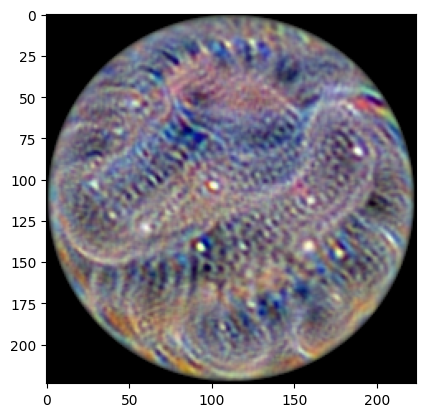

In [9]:

plt.imshow((bgr_to_rgb(patch) * patch_mask).astype(np.uint8))
plt.imsave('jellyfish_r50_1.png', (bgr_to_rgb(patch) * patch_mask).astype(np.uint8))

In [10]:
# Combine RGB and alpha channels
x = bgr_to_rgb(patch) * patch_mask
alpha = np.sum(x, axis=-1) > 0
alpha = np.uint8(alpha * 255)
res = np.dstack((x, alpha))
plt.imsave('jellyfish_r50_rgba_1.png', res.astype(np.uint8))

In [11]:
import pickle
with open('jellyfish_r50_rgba_1.pkl', 'wb') as f:
    pickle.dump(res, f)

In [12]:
patched_images = ap.apply_patch(images, scale=0.4)
def predict_model(classifier, image):
    plt.imshow(bgr_to_rgb(image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

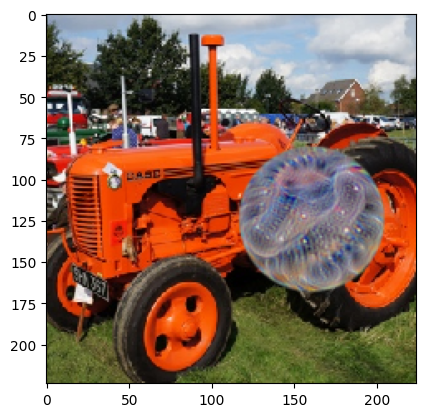

/home/adversarial_nik/ai_sec/venv/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-11-05 16:20:15.781632: W tensorflow/c/c_api.cc:304] Operation '{name:'predictions/Softmax' id:3922 op device:{requested: '', assigned: ''} def:{{{node predictions/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](predictions/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Predictions:
jellyfish    0.94
tractor      0.04
plow         0.01
thresher     0.00
water_bottle 0.00


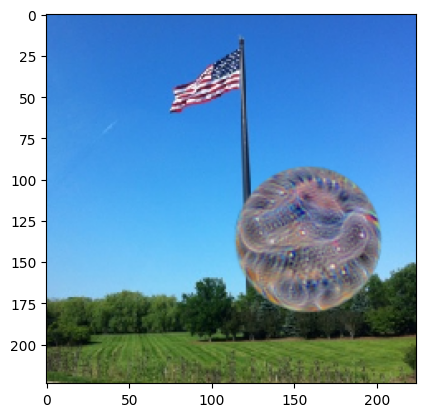

Predictions:
jellyfish  1.00
shower_cap 0.00
bubble     0.00
mushroom   0.00
flagpole   0.00


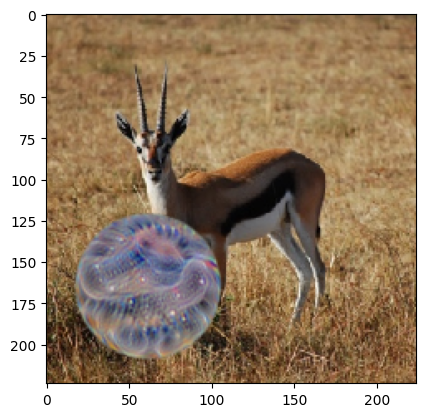

Predictions:
jellyfish  0.98
gazelle    0.02
impala     0.00
hartebeest 0.00
bubble     0.00


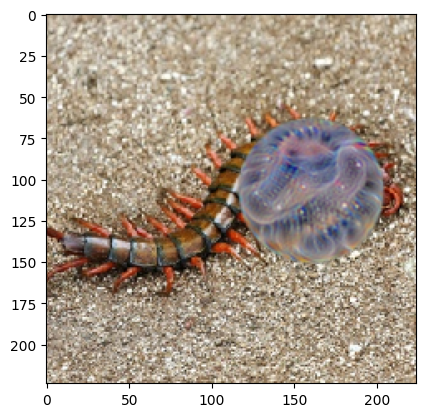

Predictions:
jellyfish    1.00
water_bottle 0.00
centipede    0.00
bubble       0.00
nipple       0.00


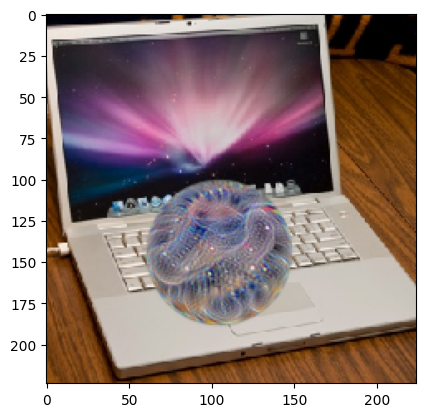

Predictions:
jellyfish 0.72
notebook  0.10
space_bar 0.03
laptop    0.03
web_site  0.03


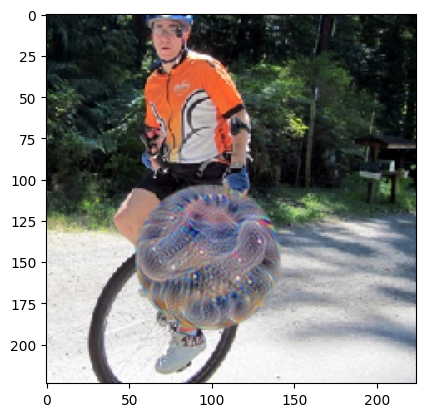

Predictions:
jellyfish             1.00
shower_cap            0.00
water_bottle          0.00
bicycle-built-for-two 0.00
unicycle              0.00


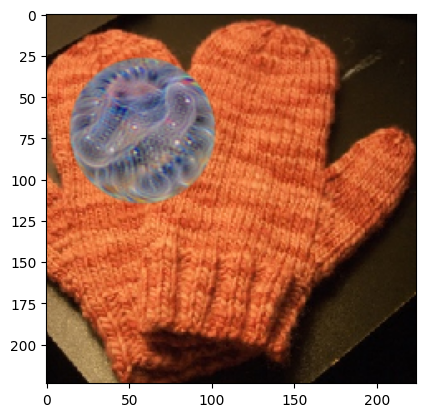

Predictions:
mitten       0.56
jellyfish    0.43
ski_mask     0.01
water_bottle 0.00
wool         0.00


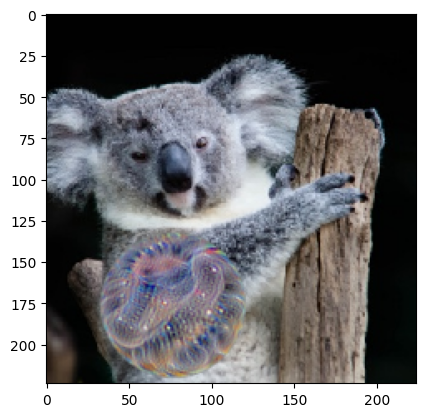

Predictions:
jellyfish 0.75
koala     0.16
bubble    0.04
trilobite 0.00
wool      0.00


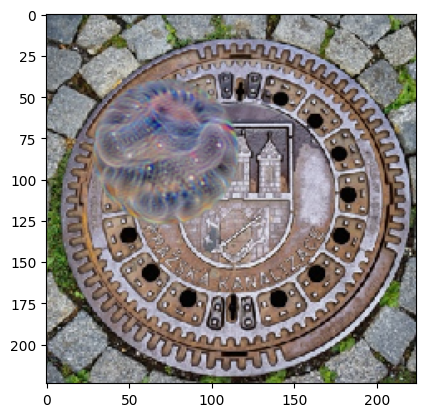

Predictions:
jellyfish     0.92
manhole_cover 0.07
centipede     0.00
coil          0.00
sundial       0.00


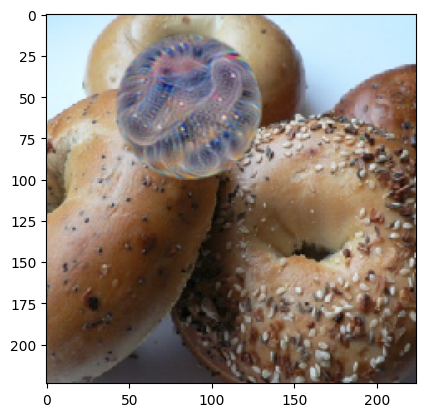

Predictions:
jellyfish  0.52
bagel      0.47
shower_cap 0.00
snail      0.00
mushroom   0.00


In [13]:
for i in range(10):
    predict_model(classifier, patched_images[i])

### Test the adversarial patch using ResNet web app